# Create Datasets from audio files

In [1]:
#  Codes are adapted from https://github.com/mdda/cnn-speech-mnist
import os

import numpy as np
import matplotlib.pyplot as plt
import scipy.misc  # for image resizing

#import scipy.io.wavfile

# pip install soundfile
import soundfile

from IPython.display import Audio as audio_playback_widget

In [2]:
f = './Datasets/happy/03-01-03-01-01-01-02.wav' #happy
# f = './Datasets/angry/03-01-05-01-01-01-02.wav' #angry

### Normally an audio file needs clipping

The following let's us examine the audio input, and choose the region of interest (in seconds from the start of the input audio file)

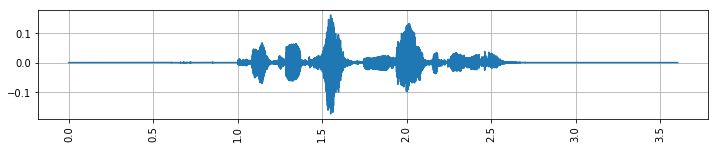

len(samples):  172973
sample_rate:  48000
samples:  [ 0.  0.  0. ...,  0.  0.  0.]
samples.shape:  (172973,)
np.amax(samples):  0.160522460938
np.amin(samples):  -0.173126220703
np.mean(samples):  2.39944420516e-07


In [3]:
# Read in the original file
samples, sample_rate = soundfile.read(f)

def show_waveform(sound):
    n_samples = sound.shape[0]

    plt.figure(figsize=(12,2))
    plt.plot(np.arange(0.0, n_samples)/sample_rate, sound)
    plt.xticks( np.arange(0.0, n_samples/sample_rate, 0.5), rotation=90 )

    plt.grid(True)

    plt.show()

show_waveform(samples)
audio_playback_widget(f)

print("len(samples): ", len(samples))
print("sample_rate: ", sample_rate)

print("samples: ", samples)
print("samples.shape: ", samples.shape)
print("np.amax(samples): ", np.amax(samples))
print("np.amin(samples): ", np.amin(samples))
print("np.mean(samples): ", np.mean(samples))

Now, let's select the region of interest

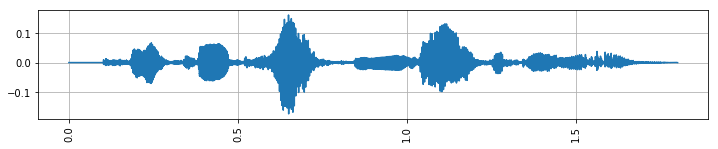

In [4]:
crop = (0.90, 2.70)  # in seconds (from waveform graph above)

cropped = samples[ int(crop[0]*sample_rate):int(crop[1]*sample_rate) ]

show_waveform(cropped)

When satisfied, write the file to disk - and update the name as appropriate (it's also possible to over-write the existing file).

Be **careful** with this step.

In [5]:
#Only do this (set it to 1) if you want to replace the file with the cropped version...
if 1:
    f = './Datasets/happy/03-01-03-01-01-01-02-cropped.wav' 
    soundfile.write(f, cropped, samplerate=sample_rate)
    print("Wrote '%s'" % (f,))

Wrote './Datasets/happy/03-01-03-01-01-01-02-cropped.wav'


## Now look at the audio spectrograms

First, we'll do this 'by hand', so that the code is laid out clearly.

In [6]:
f = './Datasets/happy/03-01-03-01-01-01-02.wav'

The following defines a function that does the spectrogram (FFT, etc), and then we define a smoothing function that will help us segment the audio into words later.

In [7]:
def spectrogram(wav_filepath):
    samples, sample_rate = soundfile.read(wav_filepath)

    # Original code from :
    # https://mail.python.org/pipermail/chicago/2010-December/007314.html

    # Rescale so that max/min are ~ +/- 1 around 0
    data_av = np.mean(samples)
    data_max = np.max(np.absolute(samples-data_av))
    sound_data = (samples - data_av)/data_max
    
    ## Parameters: 10ms step, 30ms window
    nstep = int(sample_rate * 0.01)
    nwin  = int(sample_rate * 0.03)
    nfft = 2*int(nwin/2)

    window = np.hamming(nwin)

    # will take windows x[n1:n2].  generate and loop over 
    # n2 such that all frames fit within the waveform
    nn = range(nwin, len(sound_data), nstep)

    X = np.zeros( (len(nn), nfft//2) )

    for i,n in enumerate(nn):
        segment = sound_data[ n-nwin:n ]
        z = np.fft.fft(window * segment, nfft)
        X[i,:] = np.log(np.absolute(z[:nfft//2]))
        
    return X

In [8]:
# This is a function that smooths a time-series
#   which enables us to segment the input into words by looking at the 'energy' profile
def smooth(x, window_len=31):  # , window='hanning'
    # http://scipy-cookbook.readthedocs.io/items/SignalSmooth.html
    #s = np.r_[ x[window_len-1:0:-1], x, x[-1:-window_len:-1]]
    s = np.r_[ np.zeros( ((window_len-1)//2,) ), x, np.zeros( ((window_len-1)//2,) ) ]
    w=np.hamming(window_len)
    return np.convolve(w/w.sum(), s, mode='valid') #[window_len-1 : -(window_len-1) ]

# Happy voice sample

X.shape= (358, 720)
Y.shape= (358,)
Y_crop.shape= (358,)


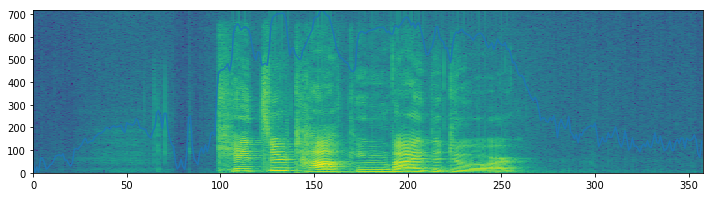

228.927419355 447.241935484


In [9]:
X = spectrogram(f)
print("X.shape=", X.shape)

#Y = np.std(X, axis=1)
Y = np.max(X, axis=1)
Y_min = np.min(Y)
Y_range = Y.max()-Y_min
Y = (Y - Y_min)/Y_range

print("Y.shape=", Y.shape)

Y_crop = np.where(Y>0.25, 1.0, 0.0)

# Apply some smoothing
Y_crop = smooth(Y_crop)

Y_crop = np.where(Y_crop>0.01, 1.0, 0.0)
print("Y_crop.shape=", Y_crop.shape)

plt.figure(figsize=(12,3))
plt.imshow(X.T, interpolation='nearest', origin='lower', aspect='auto')
plt.xlim(xmin=0)
plt.ylim(ymin=0)

plt.plot(Y * X.shape[1])

# plt.plot(Y_crop * X.shape[1])

plt.show()
#Y.min(), Y.max()
#X[100,:]
print( np.argmin(X)/248, np.argmax(X)/248 )

audio_playback_widget(f)

# Angry voice sample

In [10]:
g = './Datasets/angry/03-01-05-01-01-01-02.wav'

X.shape= (365, 720)
Y.shape= (365,)
Y_crop.shape= (365,)


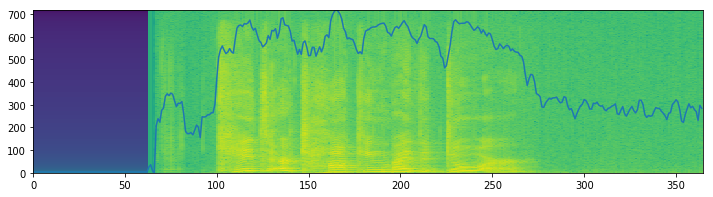

2.89919354839 479.157258065


In [11]:
X = spectrogram(g)
print("X.shape=", X.shape)

#Y = np.std(X, axis=1)
Y = np.max(X, axis=1)
Y_min = np.min(Y)
Y_range = Y.max()-Y_min
Y = (Y - Y_min)/Y_range

print("Y.shape=", Y.shape)

Y_crop = np.where(Y>0.25, 1.0, 0.0)

# Apply some smoothing
Y_crop = smooth(Y_crop)

Y_crop = np.where(Y_crop>0.01, 1.0, 0.0)
print("Y_crop.shape=", Y_crop.shape)

plt.figure(figsize=(12,3))
plt.imshow(X.T, interpolation='nearest', origin='lower', aspect='auto')
plt.xlim(xmin=0)
plt.ylim(ymin=0)

plt.plot(Y * X.shape[1])

# plt.plot(Y_crop * X.shape[1])

plt.show()
#Y.min(), Y.max()
#X[100,:]
print( np.argmin(X)/248, np.argmax(X)/248 )

audio_playback_widget(g)

# German happy voice sample

In [15]:
f = './Datasets/happy_de/03a02Fc.wav'

X.shape= (198, 240)
Y.shape= (198,)
Y_crop.shape= (198,)


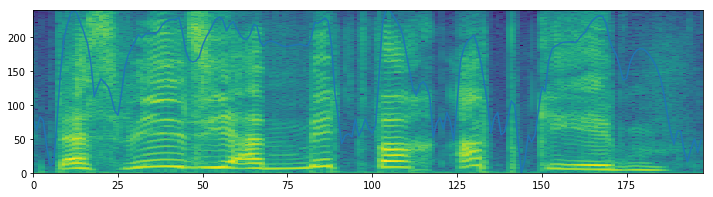

1.85483870968 11.6975806452


In [16]:
X = spectrogram(f)
print("X.shape=", X.shape)

#Y = np.std(X, axis=1)
Y = np.max(X, axis=1)
Y_min = np.min(Y)
Y_range = Y.max()-Y_min
Y = (Y - Y_min)/Y_range

print("Y.shape=", Y.shape)

Y_crop = np.where(Y>0.25, 1.0, 0.0)

# Apply some smoothing
Y_crop = smooth(Y_crop)

Y_crop = np.where(Y_crop>0.01, 1.0, 0.0)
print("Y_crop.shape=", Y_crop.shape)

plt.figure(figsize=(12,3))
plt.imshow(X.T, interpolation='nearest', origin='lower', aspect='auto')
plt.xlim(xmin=0)
plt.ylim(ymin=0)

plt.plot(Y * X.shape[1])

# plt.plot(Y_crop * X.shape[1])

plt.show()
#Y.min(), Y.max()
#X[100,:]
print( np.argmin(X)/248, np.argmax(X)/248 )

audio_playback_widget(f)

# German angry voice sample

In [17]:
f = './Datasets/angry_de/03a02Wb.wav'

X.shape= (210, 240)
Y.shape= (210,)
Y_crop.shape= (210,)


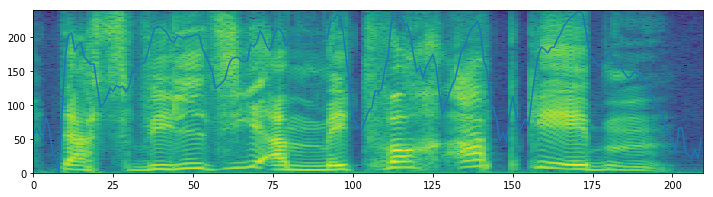

201.286290323 109.419354839


In [18]:
X = spectrogram(f)
print("X.shape=", X.shape)

#Y = np.std(X, axis=1)
Y = np.max(X, axis=1)
Y_min = np.min(Y)
Y_range = Y.max()-Y_min
Y = (Y - Y_min)/Y_range

print("Y.shape=", Y.shape)

Y_crop = np.where(Y>0.25, 1.0, 0.0)

# Apply some smoothing
Y_crop = smooth(Y_crop)

Y_crop = np.where(Y_crop>0.01, 1.0, 0.0)
print("Y_crop.shape=", Y_crop.shape)

plt.figure(figsize=(12,3))
plt.imshow(X.T, interpolation='nearest', origin='lower', aspect='auto')
plt.xlim(xmin=0)
plt.ylim(ymin=0)

plt.plot(Y * X.shape[1])

# plt.plot(Y_crop * X.shape[1])

plt.show()
#Y.min(), Y.max()
#X[100,:]
print( np.argmin(X)/248, np.argmax(X)/248 )

audio_playback_widget(f)

Work out the contiguous region of high enery (== sound) so that we can split the file into voiced segments.

In [12]:
#http://stackoverflow.com/questions/4494404/find-large-number-of-consecutive-values-fulfilling-condition-in-a-numpy-array
def contiguous_regions(condition):
    idx = []
    i = 0
    while i < len(condition):
        x1 = i + condition[i:].argmax()
        try:
            x2 = x1 + condition[x1:].argmin()
        except:
            x2 = x1 + 1
        if x1 == x2:
            if condition[x1] == True:
                x2 = len(condition)
            else:
                break
        idx.append( [x1,x2] )
        i = x2
    return idx

contiguous_regions(Y_crop>0.5)

[[53, 365]]

### Now use 'proper' audio tools for segmentation

In [13]:
# pip install python_speech_features
import python_speech_features

sample_window_step = 0.01 # in seconds (10ms)

def get_sample_features(samples, sample_rate):
    #sample_feat = python_speech_features.mfcc(samples, sample_rate, numcep=13, nfilt=26, appendEnergy=True)
    #sample_feat = python_speech_features.mfcc(samples, sample_rate, numcep=28, nfilt=56, appendEnergy=True)

    #sample_feat, e = python_speech_features.fbank(samples,samplerate=sample_rate,
    #      winlen=0.025,winstep=0.01,nfilt=26,nfft=512,
    #      lowfreq=0,highfreq=None,preemph=0.97, winfunc=lambda x:np.ones((x,)))

    features, energy = python_speech_features.fbank(samples, samplerate=sample_rate, 
                            winlen=0.025, winstep=sample_window_step, 
                            nfilt=32,nfft=2*int(sample_rate*0.025/2),
                            lowfreq=0,highfreq=None,preemph=0.25,
                            winfunc=lambda x:np.hamming( x ))
    return features, energy
    
def get_sample_isolated_words(energy, plot=False):
    log_e = np.log(energy)
    if plot: plt.plot(log_e-5)

    #log_e = smooth(log_e)
    #if plot: plt.plot(log_e)
    
    log_e_hurdle = (log_e.max() - log_e.min())*0.25 + log_e.min()

    log_e_crop = np.where(log_e>log_e_hurdle, 1.0, 0.0)
    if plot: plt.plot(log_e_crop * 25 - 2.5)

    # By smoothing, and applying a very low hurdle, we expand the crop area safely
    log_e_crop_expanded = np.where( smooth(log_e_crop, )>0.01, 1.0, 0.0)
    if plot: plt.plot(log_e_crop_expanded * 30 -5)
    
    return contiguous_regions(log_e_crop_expanded>0.5)

Redo the calculation above, but using the 'proper' tools.  Notice how the scaling, contrast, etc, are better 'looking'.  

Actually, the 'look' is something that we actually care about here.

(172973,) 48000
[[27, 311]]


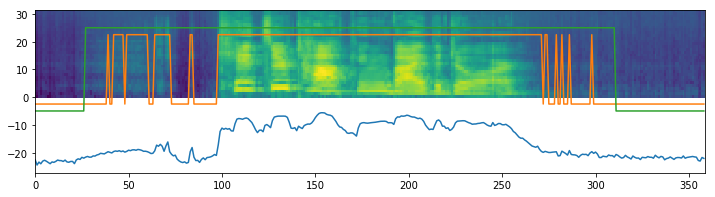

(359, 32) (359,) 9.02171077139e-09


In [14]:
samples, sample_rate = soundfile.read(f)

print(samples.shape, sample_rate)

sample_feat, energy = get_sample_features(samples, sample_rate)

plt.figure(figsize=(12,3))
plt.imshow(np.log(sample_feat.T), interpolation='nearest', origin='lower', aspect='auto')
plt.xlim(xmin=0)

word_ranges = get_sample_isolated_words(energy, plot=True)
print(word_ranges)
plt.show()

print(sample_feat.shape, energy.shape, energy[10])
audio_playback_widget(f)

### Convert WAVs to 'stamps'

Now we have some nice WAV files placed into folders which are named according to the word inside, let's create a function that preprocesses the audio clips into 'stamp' files that are essentially spectrograms with a fixed size (and ```uint8``` data type - which makes the ```numpy``` array small).

In [20]:
# Convert a given (isolated word) WAV into a 'stamp' - using a helper function

def samples_to_stamps(samples, sample_rate, stamp_period_in_sec=1.0):
    sample_feat, energy = get_sample_features(samples, sample_rate)
    
    data = np.log(sample_feat)
    
    # Now normalize each vertical slice so that the minimum energy is ==0
    data_mins = np.min(data, axis=1)
    data_min0 = data - data_mins[:, np.newaxis]
    
    # Force the data into the 'stamp size' as an image (implicit range normalization occurs)
    stamp = scipy.misc.imresize(data_min0, (224, 224), 'bilinear')
    
    # https://github.com/scipy/scipy/issues/4458 :: The stamps are stored as uint8...
    return stamp

def samples_to_stamp(samples, sample_rate):
    sample_feat, energy = get_sample_features(samples, sample_rate)
    
    data = np.log(sample_feat)
    
    # Now normalize each vertical slice so that the minimum energy is ==0
    data_mins = np.min(data, axis=1)
    data_min0 = data - data_mins[:, np.newaxis]
    
    # Force the data into the 'stamp size' as an image (implicit range normalization occurs)
    stamp = scipy.misc.imresize(data_min0, (224, 224), 'bilinear')
    
    # https://github.com/scipy/scipy/issues/4458 :: The stamps are stored as uint8...
    return stamp


def wav_to_stamp(f):
    samples, sample_rate = soundfile.read(f)
    return samples_to_stamp(samples, sample_rate)

# def wav_to_stamp(prefix, word, wav):
#     samples, sample_rate = soundfile.read( os.path.join('data', prefix, word, wav) )
#     return samples_to_stamp(samples, sample_rate)

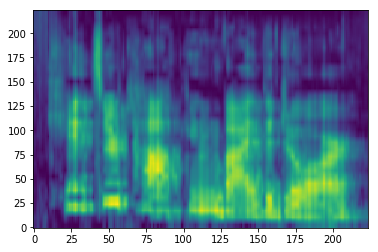

0 254
[[58 58 58 ..., 58 58 58]
 [27 27 27 ..., 56 56 56]
 [32 32 32 ..., 55 55 55]
 ..., 
 [65 65 65 ..., 17 17 17]
 [63 63 63 ..., 20 20 20]
 [46 46 46 ..., 18 18 18]]


In [23]:
# Show what the 'visual stamp' for a given word looks like
stamp = wav_to_stamp(f)

plt.imshow(stamp.T, interpolation='nearest', origin='lower', aspect='auto')
plt.show()

print( np.min(stamp), np.max(stamp) )
print(stamp)
audio_playback_widget( f )

In [26]:
scipy.misc.toimage(stamp, cmin=0.0, cmax=...).save(os.path.join('./Datasets/', "stamp.jpg"))

# Enable 'ad-hoc' look-see testing

This allows us to just pop single words, etc, into a folder, and have them labelled with the filename only (no actual label).  This is really just for show-and-tell.

In [31]:
import pickle

# Now do something similar for 'test files', create a dataset for all the audio files in the given folder

def create_dataset_from_adhoc_wavs(folder_name, save_as='.pkl', seed=13):
    stamps, labels, filenames = [], [], []
    
    for audio_file in sorted(os.listdir( os.path.join('Datasets', folder_name) )):
        filename_stub, ext = os.path.splitext(audio_file)
        if not (ext=='.wav' or ext=='.ogg'): continue
            
        samples, sample_rate = soundfile.read( os.path.join('Datasets', folder_name, audio_file) )
        sample_feat, energy = get_sample_features(samples, sample_rate)
        word_ranges = get_sample_isolated_words(energy, plot=False)
        
        word_ranges
    
        for i, wr in enumerate(word_ranges):
            wr = word_ranges[i]
            fac = int(sample_window_step*sample_rate)
            segment = samples[ wr[0]*fac:wr[1]*fac ]

            stamp = samples_to_stamp(segment, sample_rate)
            
            print("Adding : %s #%2d : (%d,%d)" % (filename_stub, i, wr[0], wr[1],))
            stamps.append(stamp)
            if folder_name == 'happy' or folder_name == 'surprised' or folder_name == 'happy_de' :
                labels.append(0)
            elif folder_name == 'angry'or folder_name == 'disgust' or folder_name == 'angry_de':
                labels.append(1)
            else:
                labels.append(-1)
            filenames.append("%s_%d" % (filename_stub, i))
    
    np.random.seed(seed)
    data_dictionary = dict(
        stamp=stamps, label=labels, 
        rand=np.random.rand( len(labels) ),
        filenames=filenames, 
    )
    ds_file = os.path.join('Datasets', folder_name+save_as)
    pickle.dump(data_dictionary, open(ds_file, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    print("Created dataset : %s" % (ds_file, ))

In [45]:
def create_jpg_datasets_from_adhoc_wavs(folder_name, dest_directory='./Datasets/jpgs/'):
#     stamps, labels, filenames = [], [], []
    
    if not os.path.exists(dest_directory):
        os.makedirs(dest_directory)
    
    for audio_file in sorted(os.listdir( os.path.join('Datasets', folder_name) )):
        filename_stub, ext = os.path.splitext(audio_file)
        if not (ext=='.wav' or ext=='.ogg'): continue
            
        samples, sample_rate = soundfile.read( os.path.join('Datasets', folder_name, audio_file) )
        sample_feat, energy = get_sample_features(samples, sample_rate)
        word_ranges = get_sample_isolated_words(energy, plot=False)
        
        word_ranges
    
        for i, wr in enumerate(word_ranges):
            wr = word_ranges[i]
            fac = int(sample_window_step*sample_rate)
            segment = samples[ wr[0]*fac:wr[1]*fac ]

            stamp = samples_to_stamp(segment, sample_rate)
            
            jpg_filename = "_".join((folder_name, filename_stub, str(i), ".jpg"))
            
            scipy.misc.toimage(stamp, cmin=0.0, cmax=...).save(os.path.join(dest_directory, jpg_filename))
            
#             print("Adding : %s #%2d : (%d,%d)" % (filename_stub, i, wr[0], wr[1],))
#             stamps.append(stamp)
#             if folder_name == 'happy' or folder_name == 'surprised' or folder_name == 'happy_de' :
#                 labels.append(0)
#             elif folder_name == 'angry'or folder_name == 'disgust' or folder_name == 'angry_de':
#                 labels.append(1)
#             else:
#                 labels.append(-1)
#             filenames.append("%s_%d" % (filename_stub, i))
    
#     np.random.seed(seed)
#     data_dictionary = dict(
#         stamp=stamps, label=labels, 
#         rand=np.random.rand( len(labels) ),
#         filenames=filenames, 
#     )
#     ds_file = os.path.join('Datasets', folder_name+save_as)
#     pickle.dump(data_dictionary, open(ds_file, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)
    print("Created jpg dataset : %s" % (dest_directory, ))

In [36]:
first_folder_name = 'happy'

In [37]:
create_dataset_from_adhoc_wavs(first_folder_name)

Adding : 03-01-03-01-01-01-01 # 0 : (11,308)
Adding : 03-01-03-01-01-01-02-cropped # 0 : (0,179)
Adding : 03-01-03-01-01-01-02 # 0 : (27,311)
Adding : 03-01-03-01-01-01-03 # 0 : (0,35)
Adding : 03-01-03-01-01-01-03 # 1 : (65,362)
Adding : 03-01-03-01-01-01-04 # 0 : (75,349)
Adding : 03-01-03-01-01-01-05 # 0 : (0,399)
Adding : 03-01-03-01-01-01-06 # 0 : (0,353)
Adding : 03-01-03-01-01-01-07 # 0 : (0,349)
Adding : 03-01-03-01-01-01-08 # 0 : (0,349)
Adding : 03-01-03-01-01-01-09 # 0 : (0,333)
Adding : 03-01-03-01-01-01-10 # 0 : (1,32)
Adding : 03-01-03-01-01-01-10 # 1 : (67,280)
Adding : 03-01-03-01-01-01-11 # 0 : (6,309)
Adding : 03-01-03-01-01-01-12 # 0 : (0,369)
Adding : 03-01-03-01-01-01-13 # 0 : (0,323)
Adding : 03-01-03-01-01-01-14 # 0 : (0,369)
Adding : 03-01-03-01-01-01-15 # 0 : (0,339)
Adding : 03-01-03-01-01-01-16 # 0 : (56,369)
Adding : 03-01-03-01-01-01-17 # 0 : (0,346)
Adding : 03-01-03-01-01-01-18 # 0 : (0,339)
Adding : 03-01-03-01-01-01-19 # 0 : (0,363)
Adding : 03-01-03-01

Adding : 03-01-03-02-02-01-17 # 0 : (0,373)
Adding : 03-01-03-02-02-01-18 # 0 : (0,376)
Adding : 03-01-03-02-02-01-19 # 0 : (0,439)
Adding : 03-01-03-02-02-01-20 # 0 : (54,356)
Adding : 03-01-03-02-02-01-21 # 0 : (4,29)
Adding : 03-01-03-02-02-01-21 # 1 : (41,360)
Adding : 03-01-03-02-02-01-22 # 0 : (23,339)
Adding : 03-01-03-02-02-01-23 # 0 : (0,323)
Adding : 03-01-03-02-02-01-24 # 0 : (26,386)
Adding : 03-01-03-02-02-02-01 # 0 : (0,393)
Adding : 03-01-03-02-02-02-02 # 0 : (48,386)
Adding : 03-01-03-02-02-02-03 # 0 : (0,51)
Adding : 03-01-03-02-02-02-03 # 1 : (71,383)
Adding : 03-01-03-02-02-02-04 # 0 : (0,35)
Adding : 03-01-03-02-02-02-04 # 1 : (37,376)
Adding : 03-01-03-02-02-02-05 # 0 : (0,339)
Adding : 03-01-03-02-02-02-06 # 0 : (0,314)
Adding : 03-01-03-02-02-02-06 # 1 : (321,359)
Adding : 03-01-03-02-02-02-07 # 0 : (0,383)
Adding : 03-01-03-02-02-02-08 # 0 : (0,393)
Adding : 03-01-03-02-02-02-09 # 0 : (0,356)
Adding : 03-01-03-02-02-02-10 # 0 : (84,344)
Adding : 03-01-03-02-02-0

In [40]:
# Read in the ad-hoc test dataset
happy_dataset = pickle.load(open(os.path.join('Datasets', 'happy.pkl'), 'rb'))

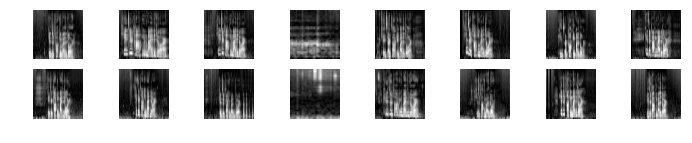

In [41]:
plt.figure(figsize=(12,2))
for pos in range(len(happy_dataset['stamp'][0:16])):  # at most 16
    plt.subplot(2, 8, pos+1)  # nrows, ncols, subplot#
    plt.imshow(happy_dataset['stamp'][pos].T, cmap='gray', origin='lower', interpolation='nearest')
    plt.axis('off')
plt.show()

In [46]:
create_jpg_datasets_from_adhoc_wavs(first_folder_name, dest_directory='./Datasets/jpgs/happy_en')

Created jpg dataset : ./Datasets/jpgs/happy_en


In [49]:
second_folder_name = 'angry'

In [50]:
create_dataset_from_adhoc_wavs(second_folder_name)

Adding : 03-01-05-01-01-01-01 # 0 : (0,386)
Adding : 03-01-05-01-01-01-02 # 0 : (49,366)
Adding : 03-01-05-01-01-01-03 # 0 : (0,17)
Adding : 03-01-05-01-01-01-03 # 1 : (37,399)
Adding : 03-01-05-01-01-01-04 # 0 : (47,369)
Adding : 03-01-05-01-01-01-05 # 0 : (0,386)
Adding : 03-01-05-01-01-01-06 # 0 : (0,376)
Adding : 03-01-05-01-01-01-07 # 0 : (0,399)
Adding : 03-01-05-01-01-01-08 # 0 : (0,369)
Adding : 03-01-05-01-01-01-09 # 0 : (0,356)
Adding : 03-01-05-01-01-01-10 # 0 : (40,368)
Adding : 03-01-05-01-01-01-11 # 0 : (0,359)
Adding : 03-01-05-01-01-01-12 # 0 : (0,426)
Adding : 03-01-05-01-01-01-13 # 0 : (0,343)
Adding : 03-01-05-01-01-01-14 # 0 : (0,359)
Adding : 03-01-05-01-01-01-15 # 0 : (0,354)
Adding : 03-01-05-01-01-01-16 # 0 : (70,396)
Adding : 03-01-05-01-01-01-17 # 0 : (0,346)
Adding : 03-01-05-01-01-01-18 # 0 : (0,389)
Adding : 03-01-05-01-01-01-19 # 0 : (11,376)
Adding : 03-01-05-01-01-01-20 # 0 : (76,323)
Adding : 03-01-05-01-01-01-21 # 0 : (39,411)
Adding : 03-01-05-01-01-0

Adding : 03-01-05-02-02-01-19 # 0 : (0,373)
Adding : 03-01-05-02-02-01-20 # 0 : (0,17)
Adding : 03-01-05-02-02-01-20 # 1 : (48,439)
Adding : 03-01-05-02-02-01-21 # 0 : (46,409)
Adding : 03-01-05-02-02-01-22 # 0 : (24,372)
Adding : 03-01-05-02-02-01-23 # 0 : (62,249)
Adding : 03-01-05-02-02-01-24 # 0 : (0,416)
Adding : 03-01-05-02-02-02-01 # 0 : (0,443)
Adding : 03-01-05-02-02-02-02 # 0 : (25,399)
Adding : 03-01-05-02-02-02-03 # 0 : (0,449)
Adding : 03-01-05-02-02-02-04 # 0 : (1,383)
Adding : 03-01-05-02-02-02-05 # 0 : (0,363)
Adding : 03-01-05-02-02-02-06 # 0 : (0,387)
Adding : 03-01-05-02-02-02-07 # 0 : (2,433)
Adding : 03-01-05-02-02-02-08 # 0 : (15,363)
Adding : 03-01-05-02-02-02-09 # 0 : (0,20)
Adding : 03-01-05-02-02-02-09 # 1 : (33,396)
Adding : 03-01-05-02-02-02-10 # 0 : (76,403)
Adding : 03-01-05-02-02-02-11 # 0 : (0,38)
Adding : 03-01-05-02-02-02-11 # 1 : (48,341)
Adding : 03-01-05-02-02-02-11 # 2 : (345,370)
Adding : 03-01-05-02-02-02-12 # 0 : (6,383)
Adding : 03-01-05-02-02-

In [51]:
angry_dataset = pickle.load(open(os.path.join('Datasets', 'angry.pkl'), 'rb'))

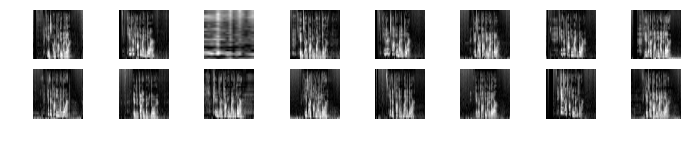

In [52]:
plt.figure(figsize=(12,2))
for pos in range(len(angry_dataset['stamp'][0:16])):  # at most 16
    plt.subplot(2, 8, pos+1)  # nrows, ncols, subplot#
    plt.imshow(angry_dataset['stamp'][pos].T, cmap='gray', origin='lower', interpolation='nearest')
    plt.axis('off')
plt.show()

In [53]:
create_jpg_datasets_from_adhoc_wavs(second_folder_name, dest_directory='./Datasets/jpgs/angry_en')

Created jpg dataset : ./Datasets/jpgs/angry_en


In [57]:
emotions_data_dictionary = dict(
    stamp=happy_dataset['stamp']+angry_dataset['stamp'], 
    label=happy_dataset['label']+angry_dataset['label'], 
    rand=np.concatenate((happy_dataset['rand'], angry_dataset['rand'])),
    filenames=happy_dataset['filenames']+angry_dataset['filenames'], 
)
emotions_file = os.path.join('Datasets', 'emotions.pkl')
pickle.dump(emotions_data_dictionary, open(emotions_file, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)


In [58]:
disgust_folder_name = 'disgust'

In [59]:
create_dataset_from_adhoc_wavs(disgust_folder_name)

Adding : 03-01-07-01-01-01-01 # 0 : (0,386)
Adding : 03-01-07-01-01-01-02 # 0 : (73,366)
Adding : 03-01-07-01-01-01-03 # 0 : (0,403)
Adding : 03-01-07-01-01-01-04 # 0 : (76,389)
Adding : 03-01-07-01-01-01-05 # 0 : (0,433)
Adding : 03-01-07-01-01-01-06 # 0 : (0,349)
Adding : 03-01-07-01-01-01-07 # 0 : (0,18)
Adding : 03-01-07-01-01-01-07 # 1 : (65,353)
Adding : 03-01-07-01-01-01-08 # 0 : (0,389)
Adding : 03-01-07-01-01-01-09 # 0 : (0,339)
Adding : 03-01-07-01-01-01-10 # 0 : (0,17)
Adding : 03-01-07-01-01-01-10 # 1 : (84,298)
Adding : 03-01-07-01-01-01-11 # 0 : (0,366)
Adding : 03-01-07-01-01-01-12 # 0 : (0,373)
Adding : 03-01-07-01-01-01-13 # 0 : (0,313)
Adding : 03-01-07-01-01-01-14 # 0 : (10,376)
Adding : 03-01-07-01-01-01-15 # 0 : (0,361)
Adding : 03-01-07-01-01-01-16 # 0 : (52,376)
Adding : 03-01-07-01-01-01-17 # 0 : (0,383)
Adding : 03-01-07-01-01-01-18 # 0 : (0,429)
Adding : 03-01-07-01-01-01-19 # 0 : (0,54)
Adding : 03-01-07-01-01-01-19 # 1 : (73,429)
Adding : 03-01-07-01-01-01-2

Adding : 03-01-07-02-02-01-21 # 0 : (0,416)
Adding : 03-01-07-02-02-01-22 # 0 : (0,419)
Adding : 03-01-07-02-02-01-23 # 0 : (0,373)
Adding : 03-01-07-02-02-01-24 # 0 : (1,423)
Adding : 03-01-07-02-02-02-01 # 0 : (0,436)
Adding : 03-01-07-02-02-02-02 # 0 : (0,403)
Adding : 03-01-07-02-02-02-03 # 0 : (0,38)
Adding : 03-01-07-02-02-02-03 # 1 : (46,76)
Adding : 03-01-07-02-02-02-03 # 2 : (80,393)
Adding : 03-01-07-02-02-02-04 # 0 : (54,393)
Adding : 03-01-07-02-02-02-05 # 0 : (0,453)
Adding : 03-01-07-02-02-02-06 # 0 : (0,396)
Adding : 03-01-07-02-02-02-07 # 0 : (0,476)
Adding : 03-01-07-02-02-02-08 # 0 : (0,386)
Adding : 03-01-07-02-02-02-09 # 0 : (0,80)
Adding : 03-01-07-02-02-02-09 # 1 : (84,354)
Adding : 03-01-07-02-02-02-10 # 0 : (55,486)
Adding : 03-01-07-02-02-02-11 # 0 : (0,373)
Adding : 03-01-07-02-02-02-12 # 0 : (2,58)
Adding : 03-01-07-02-02-02-12 # 1 : (91,396)
Adding : 03-01-07-02-02-02-13 # 0 : (0,343)
Adding : 03-01-07-02-02-02-14 # 0 : (53,379)
Adding : 03-01-07-02-02-02-15

In [60]:
disgust_dataset = pickle.load(open(os.path.join('Datasets', 'disgust.pkl'), 'rb'))

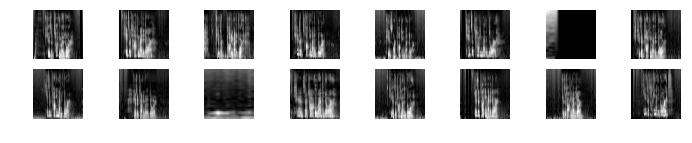

In [61]:
plt.figure(figsize=(12,2))
for pos in range(len(disgust_dataset['stamp'][0:16])):  # at most 16
    plt.subplot(2, 8, pos+1)  # nrows, ncols, subplot#
    plt.imshow(disgust_dataset['stamp'][pos].T, cmap='gray', origin='lower', interpolation='nearest')
    plt.axis('off')
plt.show()

In [62]:
create_jpg_datasets_from_adhoc_wavs(disgust_folder_name, dest_directory='./Datasets/jpgs/disgust_en')

Created jpg dataset : ./Datasets/jpgs/disgust_en


In [63]:
surprised_folder_name = 'surprised'

In [64]:
create_dataset_from_adhoc_wavs(surprised_folder_name)

Adding : 03-01-08-01-01-01-01 # 0 : (0,339)
Adding : 03-01-08-01-01-01-02 # 0 : (43,353)
Adding : 03-01-08-01-01-01-03 # 0 : (0,49)
Adding : 03-01-08-01-01-01-03 # 1 : (54,323)
Adding : 03-01-08-01-01-01-04 # 0 : (2,323)
Adding : 03-01-08-01-01-01-05 # 0 : (0,373)
Adding : 03-01-08-01-01-01-06 # 0 : (0,323)
Adding : 03-01-08-01-01-01-07 # 0 : (0,31)
Adding : 03-01-08-01-01-01-07 # 1 : (41,346)
Adding : 03-01-08-01-01-01-08 # 0 : (0,369)
Adding : 03-01-08-01-01-01-09 # 0 : (0,306)
Adding : 03-01-08-01-01-01-10 # 0 : (38,251)
Adding : 03-01-08-01-01-01-11 # 0 : (0,306)
Adding : 03-01-08-01-01-01-12 # 0 : (0,353)
Adding : 03-01-08-01-01-01-13 # 0 : (0,339)
Adding : 03-01-08-01-01-01-14 # 0 : (8,44)
Adding : 03-01-08-01-01-01-14 # 1 : (66,363)
Adding : 03-01-08-01-01-01-15 # 0 : (0,363)
Adding : 03-01-08-01-01-01-16 # 0 : (45,353)
Adding : 03-01-08-01-01-01-17 # 0 : (0,339)
Adding : 03-01-08-01-01-01-18 # 0 : (0,336)
Adding : 03-01-08-01-01-01-19 # 0 : (0,373)
Adding : 03-01-08-01-01-01-20

Adding : 03-01-08-02-02-02-06 # 0 : (0,319)
Adding : 03-01-08-02-02-02-07 # 0 : (0,315)
Adding : 03-01-08-02-02-02-08 # 0 : (0,386)
Adding : 03-01-08-02-02-02-09 # 0 : (0,343)
Adding : 03-01-08-02-02-02-10 # 0 : (26,279)
Adding : 03-01-08-02-02-02-11 # 0 : (0,306)
Adding : 03-01-08-02-02-02-12 # 0 : (5,366)
Adding : 03-01-08-02-02-02-13 # 0 : (0,329)
Adding : 03-01-08-02-02-02-14 # 0 : (45,373)
Adding : 03-01-08-02-02-02-15 # 0 : (0,333)
Adding : 03-01-08-02-02-02-16 # 0 : (0,52)
Adding : 03-01-08-02-02-02-16 # 1 : (73,356)
Adding : 03-01-08-02-02-02-17 # 0 : (0,37)
Adding : 03-01-08-02-02-02-17 # 1 : (41,353)
Adding : 03-01-08-02-02-02-18 # 0 : (0,363)
Adding : 03-01-08-02-02-02-19 # 0 : (0,326)
Adding : 03-01-08-02-02-02-20 # 0 : (43,343)
Adding : 03-01-08-02-02-02-21 # 0 : (5,353)
Adding : 03-01-08-02-02-02-22 # 0 : (0,363)
Adding : 03-01-08-02-02-02-23 # 0 : (0,329)
Adding : 03-01-08-02-02-02-24 # 0 : (11,363)
Created dataset : Datasets/surprised.pkl


In [65]:
surprised_dataset = pickle.load(open(os.path.join('Datasets', 'surprised.pkl'), 'rb'))

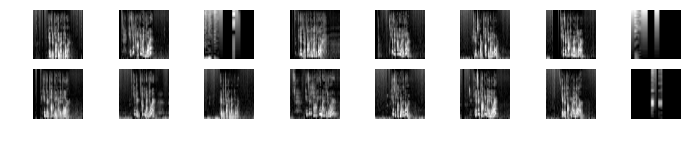

In [66]:
plt.figure(figsize=(12,2))
for pos in range(len(surprised_dataset['stamp'][0:16])):  # at most 16
    plt.subplot(2, 8, pos+1)  # nrows, ncols, subplot#
    plt.imshow(surprised_dataset['stamp'][pos].T, cmap='gray', origin='lower', interpolation='nearest')
    plt.axis('off')
plt.show()

In [67]:
create_jpg_datasets_from_adhoc_wavs(surprised_folder_name, dest_directory='./Datasets/jpgs/surprised_en')

Created jpg dataset : ./Datasets/jpgs/surprised_en


In [68]:
emotions_data_dictionary = dict(
    stamp=happy_dataset['stamp']+angry_dataset['stamp']+surprised_dataset['stamp']+disgust_dataset['stamp'], 
    label=happy_dataset['label']+angry_dataset['label']+surprised_dataset['label']+disgust_dataset['label'], 
    rand=np.concatenate((happy_dataset['rand'], angry_dataset['rand'], surprised_dataset['rand'], disgust_dataset['rand'])),
    filenames=happy_dataset['filenames']+angry_dataset['filenames']+surprised_dataset['filenames']+disgust_dataset['filenames'], 
)
emotions_file = os.path.join('Datasets', 'emotions_full.pkl')
pickle.dump(emotions_data_dictionary, open(emotions_file, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)


In [69]:
angry_de_folder_name = 'angry_de'

In [70]:
create_dataset_from_adhoc_wavs(angry_de_folder_name)

Adding : 03a01Wa # 0 : (0,187)
Adding : 03a02Wb # 0 : (0,211)
Adding : 03a02Wc # 0 : (0,149)
Adding : 03a04Wc # 0 : (0,203)
Adding : 03a05Wa # 0 : (0,343)
Adding : 03a05Wb # 0 : (0,295)
Adding : 03a07Wc # 0 : (0,208)
Adding : 03b01Wa # 0 : (0,217)
Adding : 03b01Wc # 0 : (0,292)
Adding : 03b02Wb # 0 : (0,317)
Adding : 03b03Wc # 0 : (0,384)
Adding : 03b09Wa # 0 : (0,288)
Adding : 03b10Wb # 0 : (0,216)
Adding : 03b10Wc # 0 : (0,243)
Adding : 08a01Wa # 0 : (0,160)
Adding : 08a01Wc # 0 : (0,168)
Adding : 08a02Wc # 0 : (0,186)
Adding : 08a04Wc # 0 : (0,179)
Adding : 08a05Wa # 0 : (0,292)
Adding : 08a07Wc # 0 : (0,221)
Adding : 08b01Wa # 0 : (0,330)
Adding : 08b02Wd # 0 : (0,357)
Adding : 08b03Wd # 0 : (0,407)
Adding : 08b09Wa # 0 : (0,316)
Adding : 08b09Wc # 0 : (0,330)
Adding : 08b10Wa # 0 : (0,313)
Adding : 09a01Wb # 0 : (0,169)
Adding : 09a02Wb # 0 : (0,165)
Adding : 09a04Wa # 0 : (0,183)
Adding : 09a05Wb # 0 : (0,339)
Adding : 09a05Wc # 0 : (0,317)
Adding : 09a07Wb # 0 : (0,198)
Adding :

In [71]:
angry_de_dataset = pickle.load(open(os.path.join('Datasets', 'angry_de.pkl'), 'rb'))

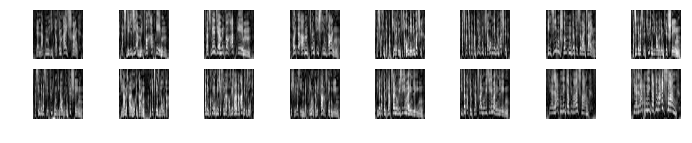

In [72]:
plt.figure(figsize=(12,2))
for pos in range(len(angry_de_dataset['stamp'][0:16])):  # at most 16
    plt.subplot(2, 8, pos+1)  # nrows, ncols, subplot#
    plt.imshow(angry_de_dataset['stamp'][pos].T, cmap='gray', origin='lower', interpolation='nearest')
    plt.axis('off')
plt.show()

In [73]:
create_jpg_datasets_from_adhoc_wavs(angry_de_folder_name, dest_directory='./Datasets/jpgs/angry_de')

Created jpg dataset : ./Datasets/jpgs/angry_de


In [74]:
happy_de_folder_name = 'happy_de'

In [75]:
create_dataset_from_adhoc_wavs(happy_de_folder_name)

Adding : 03a01Fa # 0 : (0,189)
Adding : 03a02Fc # 0 : (0,200)
Adding : 03a04Fd # 0 : (0,169)
Adding : 03a05Fc # 0 : (0,319)
Adding : 03a07Fa # 0 : (0,212)
Adding : 03a07Fb # 0 : (0,244)
Adding : 03b01Fa # 0 : (0,235)
Adding : 08a01Fd # 0 : (0,229)
Adding : 08a02Fe # 0 : (0,161)
Adding : 08a04Ff # 0 : (0,179)
Adding : 08a05Fe # 0 : (0,309)
Adding : 08a07Fd # 0 : (0,195)
Adding : 08b01Fd # 0 : (0,247)
Adding : 08b01Fe # 0 : (0,251)
Adding : 08b02Ff # 0 : (0,276)
Adding : 08b03Fe # 0 : (0,361)
Adding : 08b09Fd # 0 : (0,276)
Adding : 08b10Fd # 0 : (0,245)
Adding : 09a01Fa # 0 : (0,182)
Adding : 09a04Fd # 0 : (0,147)
Adding : 09b03Fa # 0 : (0,313)
Adding : 09b03Fd # 0 : (0,330)
Adding : 10a02Fa # 0 : (0,151)
Adding : 10a04Fd # 0 : (0,152)
Adding : 10b01Fa # 0 : (0,242)
Adding : 10b10Fc # 0 : (0,220)
Adding : 11a02Fb # 0 : (0,178)
Adding : 11a04Fd # 0 : (0,186)
Adding : 11a05Fb # 0 : (0,353)
Adding : 11a05Fc # 0 : (0,392)
Adding : 11b01Fc # 0 : (0,254)
Adding : 11b02Fd # 0 : (0,310)
Adding :

In [76]:
happy_de_dataset = pickle.load(open(os.path.join('Datasets', 'happy_de.pkl'), 'rb'))

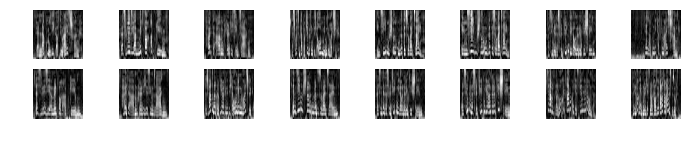

In [77]:
plt.figure(figsize=(12,2))
for pos in range(len(happy_de_dataset['stamp'][0:16])):  # at most 16
    plt.subplot(2, 8, pos+1)  # nrows, ncols, subplot#
    plt.imshow(happy_de_dataset['stamp'][pos].T, cmap='gray', origin='lower', interpolation='nearest')
    plt.axis('off')
plt.show()

In [78]:
create_jpg_datasets_from_adhoc_wavs(happy_de_folder_name, dest_directory='./Datasets/jpgs/happy_de')

Created jpg dataset : ./Datasets/jpgs/happy_de


In [79]:
emotions_data_dictionary = dict(
    stamp=happy_dataset['stamp']+angry_dataset['stamp']+happy_de_dataset['stamp']+angry_de_dataset['stamp'], 
    label=happy_dataset['label']+angry_dataset['label']+happy_de_dataset['label']+angry_de_dataset['label'], 
    rand=np.concatenate((happy_dataset['rand'], angry_dataset['rand'], happy_de_dataset['rand'], angry_de_dataset['rand'])),
    filenames=happy_dataset['filenames']+angry_dataset['filenames']+happy_de_dataset['filenames']+angry_de_dataset['filenames'], 
)

emotions_file = os.path.join('Datasets', 'emotions_en_de.pkl')
pickle.dump(emotions_data_dictionary, open(emotions_file, 'wb'), protocol=pickle.HIGHEST_PROTOCOL)